In [a previous notebook](/posts/building_infiltration_example/), I explored building infiltration due to forest fire smoke and noted that ambient conditions would impact the scenario, in this scenario I continue exploring building infiltration and examine the sensitivity of infiltration to changes in ambient conditions. In this case the scenario is a release of chlorine from a storage cylinder creating a cloud that moves downwind to a building. We would like to know what impact this has on the interior conditions of the building while also taking the opportunity to evaluate the impact of changes in ambient weather conditions.

## The Scenario

The scenario is the catastrophic failure of a liquid chlorine cylinder, perhaps one being used as part of a water treatment facility. The release is outdoors and a small building is downwind of the release, which can be occupied and so the infiltration of chlorine is important.

### Release Parameters

For simplicity suppose the entire contents of the cylinder are released essentially immediately and form a neutrally buoyant cloud. The mass of the release is [the mass of chlorine in the cylinder](https://industry.airliquide.us/chlorine) which we can assume to be 68kg. [CAMEO Chemicals](https://cameochemicals.noaa.gov/chemical/2862) lists the three emergency response planning guideline (ERPG) levels for chlorine as 1ppm, 3ppm, and 20ppm respectively.

Suppose the release is 1m off the ground and is otherwise the center of the coordinate system.

### Building Parameters

The building is a small one story structure 100m downwind of the release point. For the scenario it will be taken as a given that the building volume is 255 m³ and the equivalent leak area is 690 cm². For simplicity any obstructions around the building are ignored.

### Weather Parameters

For neutrally buoyant gaussian dispersion a class *F* Pasquill stability is [the worst case scenario](https://aefarrell.github.io/2020/12/12/worst_case_weather/), this leads to the least dispersion and thus greatest concentrations downwind. The windspeed is initially assumed to be 1.5 m/s.

|             |                 |
|------------:|-----------------|
| *m*         | 68 kg           |
| *erpg-1*    | 1 ppm           |
| *erpg-2*    | 3 ppm           |
| *erpg-3*    | 20 ppm          |
| *h*         | 1 m             |
| *d*         | 100 m           |
| $A_l$       | 6.90×10⁻² m²    |
| *V*         | 255 m³          |
| *stability* | F               |
| *u*         | 1.5 m/s         |

In [1]:
using Contour, Plots, OrdinaryDiffEq, Statistics, SpecialFunctions, ForwardDiff, Roots


In [2]:
#| output: false

m     = 68.0   # mass of chlorine released, kg
MW    = 70.9   # molar mass chlorine, kg/kmol
MVC   = 24.465 # molar volume at 25C and 1atm, m3/kmol

ppm_to_kg(ppm) = (ppm*1e-6)*(MW/MVC)
erpg1 = ppm_to_kg(1) # erpgs for chlorine, kg/m3
erpg2 = ppm_to_kg(3)
erpg3 = ppm_to_kg(20)

h   = 1.0      # height of release point, m

d   = 100.0    # downwind distance to building, m
Aₗ  = 6.90e-2  # equivalent leak area of building, m2
V   = 255.0    # volume of building, m3

u   = 1.5      # windspeed m/s

1.5

## Air Dispersion

### Gaussian Puff Model

The simplest model for a neutrally buoyant cloud is a [gaussian disperison model](/posts/gaussian_dispersion_example/), in this case because the cylinder is assumed to fail catastrophically the release can be treated as instantaneous and so we use a gaussian puff model.

It is often worth-while to estimate the initial dimensions of the cloud and then calculate a *virtual* emission point from which the release is assumed to take place. This is especially useful if the area immediately around the release point is of interest as the gaussian model assumes all of the mass is initially concentrated in a single point. However for a simple screening just using the default dispersion model is likely fine, and more conservative. The model gives the concentration as a gaussian distribution in the x, y, and z directions, while also adding in a term to account for ground reflection (mass cannot disperse below groundlevel)[@ccps-1996 page 75]


$$ c_{puff}(x,y,z,t) = { m \over { (2 \pi)^{3/2} \sigma_x \sigma_y \sigma_z } } 
\exp \left( -\frac{1}{2} \left( {x - ut} \over \sigma_x \right)^2 \right) 
\exp \left( -\frac{1}{2} \left( {y} \over \sigma_y \right)^2 \right) $$

$$ \times \left[ \exp \left( -\frac{1}{2} \left( {z - h} \over \sigma_z \right)^2 \right) + \exp \left( -\frac{1}{2} \left( {z + h} \over \sigma_z \right)^2 \right)\right]$$


The parameters σx, σy, and σz are generally found using empirically derived correlations that are functions of the downwind distance to the center of the puff *x<sub>c</sub>* and atmospheric stability.

In [3]:
#| output: false

function c_puff(x,y,z,t; # point in space
                m, u, h, # parameters of the problem
                σx::Function, σy::Function, σz::Function)
    xc = u*t # center of the cloud
    sx = σx(xc)
    sy = σy(xc)
    sz = σz(xc)
    
    C1 = m / ( (2*π)^(1.5) * sx * sy * sz )
    C2 = exp(-0.5*((x-xc)/sx)^2)
    C3 = exp(-0.5*(y/sy)^2)
    C4 = ( exp(-0.5*((z-h)/sz)^2) + exp(-0.5*((z+h)/sz)^2) )
    
    c = C1*C2*C3*C4
    
    return isnan(c) ? 0.0 : c
end

c_puff (generic function with 1 method)

### Dispersion Parameters

The dispersion parameters for puff models are not, in general, as well developed as for plume models, the following values were interpolated from a sparser set of correlations and it is worth keeping in mind. It is also worth noting that the dispersion parameters are where the impact of different windspeeds will be made most apparent as [stability is a function of windspeed](/posts/worst_case_weather/).


#### Dispersion parameters for a Gaussian puff model[@ccps-1996]

| Stability | $\sigma_x = \sigma_y$ | $\sigma_z$        | Max Windspeed |
|:---------:|:---------------------:|:-----------------:|:-------------:| 
| A         | $ 0.18 x^{0.92} $     | $ 0.60 x^{0.75} $ | 3 m/s         |
| B         | $ 0.14 x^{0.92} $     | $ 0.53 x^{0.73} $ | 5 m/s         |
| C         | $ 0.10 x^{0.92} $     | $ 0.34 x^{0.71} $ | 6 m/s         |
| D         | $ 0.06 x^{0.92} $     | $ 0.15 x^{0.70} $ |               |
| E         | $ 0.04 x^{0.92} $     | $ 0.10 x^{0.65} $ | 5 m/s         |
| F         | $ 0.02 x^{0.89} $     | $ 0.05 x^{0.61} $ | 3 m/s         |


In [4]:
#| output: false
# Class F 

σx(x) = 0.02*x^0.89
σy(x) = 0.02*x^0.89
σz(x) = 0.05*x^0.61

σz (generic function with 1 method)

### Outdoor Concentration

The outdoor concentration can be calculated at any point using the above equations and below is an animation showing the cloud moving from the release point down to the location of the center of the building. The horizontal slice is at 1m elevation, and the vertical slice is at 0m crosswind distance, the center planes of the cloud.

As is clear, for a very stable cloud the dispersion is small relative to the distance traveled (the cross wind distance is exaggerated for visibility) and the bulk of the mass of chlorine is contained in a 10m diameter ball by the time it reaches the building.

[ Info: Saved animation to /home/allan/Code/notes/notebooks/tmp.gif


Plots.AnimatedGif("/home/allan/Code/notes/notebooks/tmp.gif")
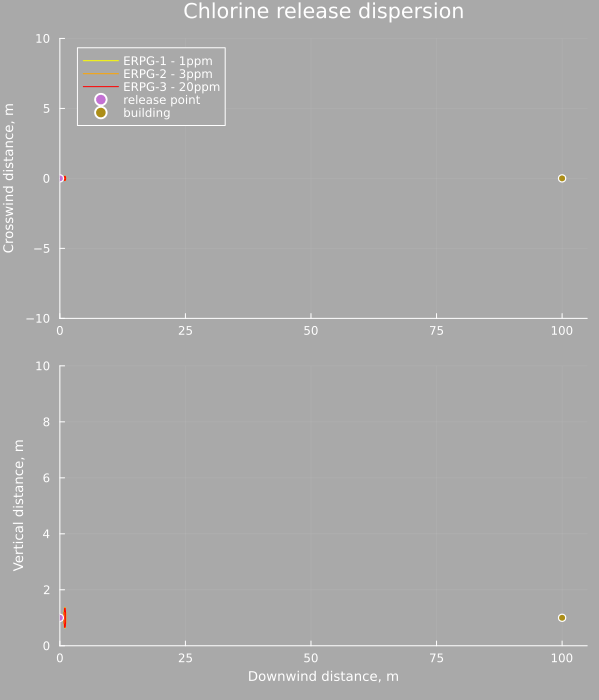

In [5]:
#| echo: false
#| label: fig-disp
#| fig-cap: "Dispersion of an instantaneous release of chlorine."

function lvlcoords(xs, ys, zs, c)
    lvl = Contour.contour(xs, ys, zs, c)
    line = lines(lvl)[1]
    return coordinates(line)
end

let
    xs = 0:0.05:(1.05*d)
    ys = -10.0:0.05:10.0
    zs = 0:0.05:10.0

    @gif for i ∈ 1:100
        t = (i/100)*(d/u)

        c_xy = [c_puff(x, y, h, t; m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)*1e6 for x in xs, y in ys]
        c_xz = [c_puff(x, 0, z, t; m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)*1e6 for x in xs, z in zs]

        # Horizontal
        p1 = plot(title="Chlorine release dispersion",
              xlim= (0, 1.05*d),
              ylim= (-10, 10), ylabel="Crosswind distance, m",
              labelfontsize=9,
              legend= :topleft,
              legendtitlefontsize=8,
              background_color=:darkgrey,
              foreground_color=:white)
        plot!( p1, lvlcoords(xs, ys, c_xy, erpg1*1e6), color=:yellow, lab="ERPG-1 - 1ppm")
        plot!( p1, lvlcoords(xs, ys, c_xy, erpg2*1e6), color=:orange, lab="ERPG-2 - 3ppm")
        plot!( p1, lvlcoords(xs, ys, c_xy, erpg3*1e6), color=:red, lab="ERPG-3 - 20ppm")
        plot!( p1, [0], [0], seriestype = :scatter, lab="release point")
        plot!( p1, [d], [0], seriestype = :scatter, lab="building")


        # Vertical
        p2 = plot(xlim= (0, 1.05*d), xlabel="Downwind distance, m",
              ylim= (0, 10), ylabel="Vertical distance, m",
              labelfontsize=9,
              legend=false,
              legendtitlefontsize=8,
              background_color=:darkgrey,
              foreground_color=:white)
        plot!( p2, lvlcoords(xs, zs, c_xz, erpg1*1e6), color=:yellow, lab="ERPG-1 - 1ppm")
        plot!( p2, lvlcoords(xs, zs, c_xz, erpg2*1e6), color=:orange, lab="ERPG-2 - 3ppm")
        plot!( p2, lvlcoords(xs, zs, c_xz, erpg3*1e6), color=:red, lab="ERPG-3 - 20ppm")
        plot!( p2, [0], [h], seriestype = :scatter, lab="release point")
        plot!( p2, [d], [h], seriestype = :scatter, lab="building")

        l = @layout [a; c]

        plot(p1, p2, layout=l, size=(600,700))


    end

end

The concentration as a function of time also shows how brief the exposure is at this point. A rapid pulse of chlorine passes over the area and is gone within a few seconds. However the concentration at that time is millions of times larger than the ERPG-1 limit (note the units, the scale is in kg/m³ whereas the ERPG limits are on the order of mg/m³)

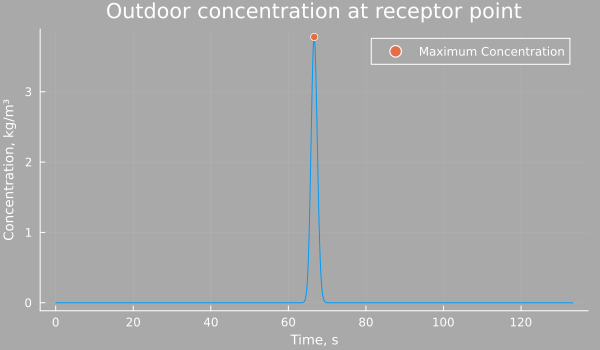

In [6]:
#| echo: false
#| label: fig-conc-v-t
#| fig-cap: "Outdoor concentration at the receptor as a function of time"
let
    t = 0:0.1:2*(d/u)

    rcpt_conc = [c_puff(d, 0, h, t′; m=m, u=u, h=h, σx=σx, σy=σy, σz=σz) for t′ in t]

    plot(t, rcpt_conc, lab=false,
         background_color=:darkgrey, foreground_color=:white,
         title="Outdoor concentration at receptor point",
         labelfontsize=9,
         xlabel="Time, s",
         ylabel="Concentration, kg/m³", size=(600,350))
    plot!([d/u], [c_puff(d, 0, h, d/u; m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)], seriestype=:scatter, lab="Maximum Concentration")

end

The concentration along the centerline of the cloud is also worth looking at, as this provides some context for the extent of the downwind impacts of the release.

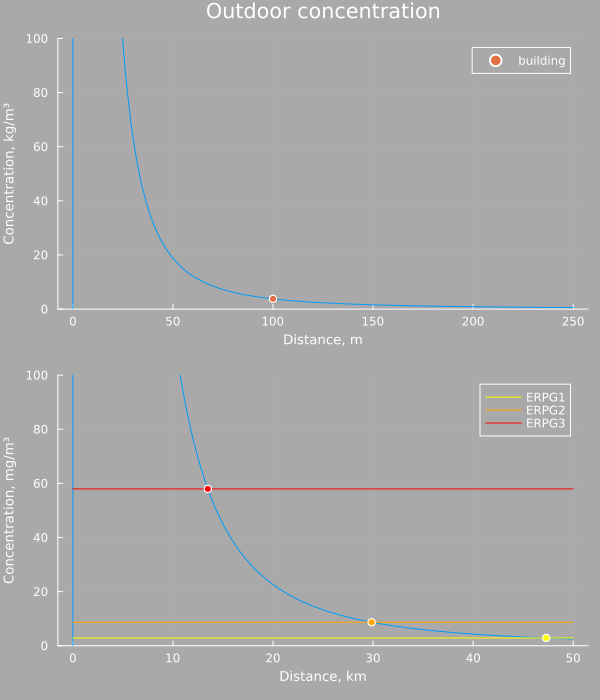

Downwind distance to ERPG-3 (outdoors) 13.5km
Downwind distance to ERPG-2 (outdoors) 29.9km
Downwind distance to ERPG-1 (outdoors) 47.3km


In [7]:
#| echo: false
#| label: fig-centerline
#| fig-cap: "Centerline concentration of the puff as a function of travel distance."
let
    ds = 0:1:250
    ys = [c_puff(d′, 0, h, (d′/u); m=m, u=u, h=h, σx=σx, σy=σy, σz=σz) for d′ in ds]
    
    erpg_dist(d) = c_puff(d, 0, h, (d/u); m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)

    dist_erpg1 = find_zero((x)-> erpg_dist(x)-erpg1, 4e4)
    dist_erpg2 = find_zero((x)-> erpg_dist(x)-erpg2, 3e4)
    dist_erpg3 = find_zero((x)-> erpg_dist(x)-erpg3, 1.5e4)

    p1 = plot(ds, ys, lab=false,
         background_color=:darkgrey, foreground_color=:white,
         title="Outdoor concentration",
         labelfontsize=9,
         xlabel="Distance, m",
         ylabel="Concentration, kg/m³",
         ylim=(0, 100.0))
    plot!(p1, [d], [c_puff(d, 0, h, (d/u); m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)], 
          seriestype=:scatter, lab="building")

    long_distance = collect(0:5:5e4).*0.001
    long_ys = [c_puff(d′*1000, 0, h, (d′*1000/u); m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)*1e6 for d′ in long_distance]
    
    p2 = plot(long_distance, long_ys, lab=false,
         background_color=:darkgrey, foreground_color=:white,
         labelfontsize=9,
         xlabel="Distance, km",
         ylabel="Concentration, mg/m³",
         ylim=(0, 100.0))
    plot!(p2, [long_distance[1], long_distance[end]], [erpg1, erpg1].*1e6, color=:yellow, lab="ERPG1")
    plot!(p2, [long_distance[1], long_distance[end]], [erpg2, erpg2].*1e6, color=:orange, lab="ERPG2")
    plot!(p2, [long_distance[1], long_distance[end]], [erpg3, erpg3].*1e6, color=:red, lab="ERPG3")
    plot!(p2, [dist_erpg3*1e-3], [erpg3*1e6], lab=false, seriestype=:scatter, color=:red)
    plot!(p2, [dist_erpg2*1e-3], [erpg2*1e6], lab=false, seriestype=:scatter, color=:orange)
    plot!(p2, [dist_erpg1*1e-3], [erpg1*1e6], lab=false, seriestype=:scatter, color=:yellow)
    
    l = @layout [a; b]
    ps = plot(p1, p2, layout=l, size=(600,700))
        
    display(ps)
    println("Downwind distance to ERPG-3 (outdoors) $(round(dist_erpg3*1e-3; digits=1))km")
    println("Downwind distance to ERPG-2 (outdoors) $(round(dist_erpg2*1e-3; digits=1))km")
    println("Downwind distance to ERPG-1 (outdoors) $(round(dist_erpg1*1e-3; digits=1))km")
    
end

Clearly this release presents a serious hazard, one would have to travel downwind over 10km to be below the ERPG-3 line and nearly 50km to be below the ERPG-1 line. Though, keep in mind, this is for instantaneous exposure and not overall dose.

## Building Infiltration
### Single Zone Model

The [single zone model](/posts/building_infiltration_example/) assumes the air within the building is generally well mixed and well described by a single concentration. This is approximately true over long timescales, however in the situation of the brief pulse of chlorine passing over the building this assumption may breakdown and is a critical weakness of the discussion that follows.

Very likely in the ~10s it takes for the cloud to pass very little of it will have had time to diffuse into the interior space of the building and the interior mixing (or lack thereof) will be a significant slow step in the overall mass transfer.

The single zone model, however, will work as a first pass at least, and in this model the interior concentration is related to the outside concentration by the following ODE[@lees-1996 section 15.51]

$$\frac{d}{dt} c_i(t) = f \left( c_i, \lambda, t \right) = \lambda \cdot \left( c_o(t) - c_i(t) \right) $$


Where *cᵢ* is the inside concentration, *cₒ* the outside concentration, and *λ* the natural ventilation rate of the building. 

The natural ventilation rate itself is a function of windspeed, the temperature difference between inside and outside, and how leaky the building is. 

The model is defined in a more generic way for now as this will be more useful later.

In [8]:
#| output: false
f(cᵢ, λ, t; cₒ=zero) = λ*(cₒ(t) - cᵢ)

f(g) = (cᵢ, λ, t) -> f(cᵢ, λ, t; cₒ=g)

f (generic function with 2 methods)

### Simplified ASHRAE Model

The last parameter we need to estimate before solving the problem is the ventilation rate, *λ*, which can be estimated using the simplified ASHRAE model[@ashrae-2017 chapter 16]

$$\lambda = \frac{Q}{V} \\
Q = A_L \sqrt{ C_s \vert \Delta T \vert + C_w u^2 } \\
\lambda = \frac{A_L}{V} \sqrt{ C_s \vert \Delta T \vert + C_w u^2 } $$

Where $A_L$ and $V$ were given earlier, $C_s$ and $C_w$ are tabulated constants, $\Delta T$ is the difference between indoor and outdoor temperatures, in *K*, and *u* the windspeed, in m/s, and the ventilation rate is in s⁻¹.

In this case the indoor and outdoor temperature are assumed to be the same for simplicity[^ashrae]

|       |Shelter Class| 1 Story  | 2 Story  | 3 Story  |
|:-----:|:-----------:|:--------:|:--------:|:--------:|
| $C_s$ | all         | 14.5×10⁻³| 29.0×10⁻³| 43.5×10⁻³|
| $C_w$ | 1           | 31.9×10⁻³| 42.0×10⁻³| 49.4×10⁻³|
|       | 2           | 24.6×10⁻³| 32.5×10⁻³| 38.2×10⁻³|
|       | 3           | 17.4×10⁻³| 23.1×10⁻³| 27.1×10⁻³|
|       | 4           | 10.4×10⁻³| 13.7×10⁻³| 16.1×10⁻³|
|       | 5           | 3.20×10⁻³| 4.20×10⁻³| 4.90×10⁻³|


With the shelter class defined as
1. No obstructions or local shielding
2. Isolated rural home
3. Another building across the street
4. Urban buildings on larger lots, with the nearest building >1 building height away
5. Immediately adjacent buildings (closer than 1 building height)

For this scenario we are assuming the (one-story) building is isolated and there are no obstructions or local shielding, so the class is *1*.

[^ashrae]: Note that the constants have been adjusted such that the leak area is in m², in the ASHRAE handbook the leak area is in cm²

In [9]:
# 1 Story building, shelter class 1

λ(ΔT, u; Aₗ, V, Cs, Cw) = (Aₗ/V)*√(Cs*abs(ΔT)+Cw*u^2)

λ₀ = λ(0.0, u, Aₗ=Aₗ, V=V, Cs=14.5e-3, Cw=31.9e-3)

7.249290622734888e-5

## Indoor Concentration

The indoor concentration is calculated simply by solving the ODE with the initial condition that the indoor concentration is zero. Since the pulse of chlorine is so brief it is important to be careful with the integrator, typical variable step integrators can step right over brief pulses and miss them entirely. To counteract that the first phase of the response, up until twice the time it takes for the wind to travel the distance, is solved using a maximum timestep of 1s, the remainder is left free to the solver to adjust as necessary to meet the tolerances.

In [10]:
# puff model, note the units have changed to mg/m³

cₒ(t) = c_puff(d, 0, h, t; m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)*1e6

c0 = 0.0       # initial condition
sys = f(cₒ)

tsp1 = (0.0, 2*d/u)
prb1 = ODEProblem(sys, c0, tsp1, λ₀)
sln1 = solve(prb1, Tsit5(), dtmax=1);

In [11]:
c0_2 = sln1[end]
tsp2 = (tsp1[end], 2.5*(1/λ₀))
prb2 = ODEProblem(sys, c0_2, tsp2, λ₀)
sln2 = solve(prb2, Tsit5());

This is a very conservative model. It assumes all of the mass transfer occurs at a point, which happens to be where the maximum outdoor concentration will be, and that interior mixing is essentially instantaneous. It also has a significant weakness in that it assumes the building does not impede the movement of the cloud. If the building is very small relative to the cloud this might be reasonable, but in this case the cloud is quite concentrated and the deflection around the building is important.

The first assumption can be moderated by taking an average outdoor concentration over the building footprint. In this case I assume the building is a 10m×10m square just for demonstration. This tries to capture the reality that not all of the building is being exposed to an equally high concentration and that an effective outdoor concentration might be better estimated as a spatial average. These points are hanging in space at the centerline of the cloud and as such are exposed to the highest concentrations. Instead of a slice like this, a more fully featured box could be used, but at that point it would probably be more useful to look into the ways the building itself is deflecting and shaping the cloud. Recall that the cloud is essentially passing through the building in this model.

In [12]:
#| output: false
box_x = (d-5):1:(d+5)
box_y = -5:1:5

function box_average(t)
    cs = [ c_puff(x, y, h, t; m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)*1e6
           for x in box_x, y in box_y ]
    return mean(cs)
end

box_average (generic function with 1 method)

In [13]:
sys_avg = f(box_average)

tsp_box = (0.0, 2*d/u)
prb_box = ODEProblem(sys_avg, c0, tsp_box, λ₀)
sln_box = solve(prb_box, Tsit5(), dtmax=1);

In [14]:
c0_box2 = sln_box[end]
tsp_box2 = (tsp_box[end], 2.5*(1/λ₀))
prb_box2 = ODEProblem(sys_avg, c0_box2, tsp_box2, λ₀)
sln_box2 = solve(prb_box2, Tsit5());

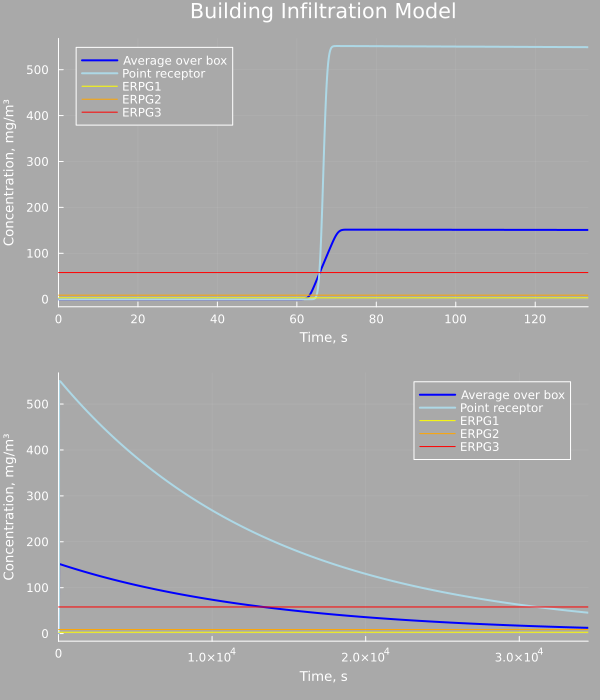

In [15]:
#| echo: false
#| label: fig-bldg-model
#| fig-cap: "Indoor concentrations assuming a linear ventillation model, showing both the building as a point source and as averaged box."
let 
       
    p1= plot(sln_box, lab="Average over box", color=:blue, linewidth=2)
    plot!(p1, sln1, lab="Point receptor", color=:lightblue, linewidth=2)
    plot!(p1, [tsp_box[1], tsp_box[end]], [erpg1, erpg1].*1e6, color=:yellow, lab="ERPG1")
    plot!(p1, [tsp_box[1], tsp_box[end]], [erpg2, erpg2].*1e6, color=:orange, lab="ERPG2")
    plot!(p1, [tsp_box[1], tsp_box[end]], [erpg3, erpg3].*1e6, color=:red, lab="ERPG3")
    plot!(p1, title="Building Infiltration Model",
          background_color=:darkgrey, foreground_color=:white,
          ylabel= "Concentration, mg/m³", 
          xlabel="Time, s",
          labelfontsize=9,
          legend=:topleft,
          legendtitlefontsize=8,
          size=(600,400))
  
    p2= plot(sln_box, color=:blue, lab=false)
    plot!(p2, sln_box2, color=:blue, lab="Average over box", linewidth=2)
    plot!(p2, sln1, color=:lightblue, lab=false)
    plot!(p2, sln2, color=:lightblue, lab="Point receptor", linewidth=2)
    plot!(p2, [tsp_box[1], tsp_box2[end]], [erpg1, erpg1].*1e6, color=:yellow, lab="ERPG1")
    plot!(p2, [tsp_box[1], tsp_box2[end]], [erpg2, erpg2].*1e6, color=:orange, lab="ERPG2")
    plot!(p2, [tsp_box[1], tsp_box2[end]], [erpg3, erpg3].*1e6, color=:red, lab="ERPG3")
    plot!(p2, background_color=:darkgrey, foreground_color=:white,
          ylabel= "Concentration, mg/m³",
          xlabel = "Time, s",
          labelfontsize=9,
          xlim = (tsp_box[1], tsp_box2[end]),
          legend = :topright,
          legendtitlefontsize = 8,
          size=(600,400))
    
    l = @layout [a ;b]
    plot(p1, p2, layout=l, size=(600,700))
end

In either the single point or averaged outdoor concentration models the indoor concentration rapidly rises above the ERPG-3 limit, which is very bad, and then slowly decays over time[^concs]. In this case almost immediately after the cloud has passed the indoor space is more concentrated in Chlorine than the outside air. At the very least this suggests that the building is not a good shelter in place location, or at least a much more detailed analysis of building infiltration would be needed to show that it *was* a good shelter in place location.

[^concs]: Note that the indoor concentrations are in mg/m³ whereas the outdoor concentration peaks in the kg/m³, so the building is doing something, it is reducing the indoor concentration by several orders of magnitude, it just isn't enough

## Sensitivity

For the scenario modeling I approached the problem in a very general way such that the methods for solving the indoor concentration didn't depend explicitly upon the model of the outdoor concentration. Which is why it was solved numerically. This is a very useful way of approaching things, especially from a code re-use point of view.

However, in this particular case, if we take the outdoor concentration to be simply the gaussian puff model at a single point then this ODE can be solved analytically and that is useful for exploring the system's sensitivity to windspeed, atmospheric stability, etc.

Starting with the original puff model for the outside concentration

$$ c_{o}(x,y,z,t) = { m \over { (2 \pi)^{3/2} \sigma_x \sigma_y \sigma_z } } 
\exp \left( -\frac{1}{2} \left( {x - ut} \over \sigma_x \right)^2 \right) 
\exp \left( -\frac{1}{2} \left( {y} \over \sigma_y \right)^2 \right) $$

$$ \times \left[ \exp \left( -\frac{1}{2} \left( {z - h} \over \sigma_z \right)^2 \right) + \exp \left( -\frac{1}{2} \left( {z + h} \over \sigma_z \right)^2 \right)\right] $$

We can split this into the product of three gaussians:

$$ c_{o}(x,y,z,t) = m \left[{ \exp \left( -\frac{1}{2} \left( {x - ut} \over \sigma_x \right)^2 \right) \over { \sqrt{2 \pi} \sigma_x } } \right]
\left[{ \exp \left( -\frac{1}{2} \left( {y} \over \sigma_y \right)^2 \right) \over { \sqrt{2 \pi} \sigma_y } } \right]  $$

$$ \times { 1 \over { \sqrt{2 \pi} \sigma_z } } \left[ \exp \left( -\frac{1}{2} \left( {z - h} \over \sigma_z \right)^2 \right) + \exp \left( -\frac{1}{2} \left( {z + h} \over \sigma_z \right)^2 \right)\right]$$

$$ c_{o}(x,y,z,t) = m C_x(x, t) C_y(x, y) C_z(x, z)$$

and noting that only $C_x$ depends on time we can collect the other stuff into a big constant called $C_1$, giving us<a href="#fn-7" class="sidenote-number"></a><span class="sidenote" id="fn-7">I am assuming the dispersion parameters are all constant, this is not strictly true as they all depend upon the downwind location of the center of the puff, which is a function of time</span>


$$ c_{o}(t) = C_1 { 1 \over { \sqrt{2 \pi} \sigma_x } }\exp \left( -\frac{1}{2} \left( {x - ut} \over \sigma_x \right)^2 \right) $$

this is a gaussian in time, let $\mu = \frac{x}{u}$ and $\sigma_t = \frac{\sigma_x}{u}$

$$ c_{o}(t) = { C_1 \over u } { 1 \over { \sqrt{2 \pi} \sigma_t } }\exp \left( -\frac{1}{2} \left( {t - \mu} \over \sigma_t \right)^2 \right) $$

suppose the Laplace transform of this is $C_{o}(s)$, and [taking the Laplace transform](/posts/building_infiltration_example/#a-control-systems-approach) of the ODE we arrive at

$$ C_{i}(s) = { \lambda \over {s + \lambda} } C_{o}(s) $$

where $C_{i}(s)$ is the Laplace transform of $c_{i}(t)$, inverting the Laplace transform leads us to conclude

$$ c_{i}(t) = { C_1 \over u } \int_{0}^{\infty} \lambda \exp \left( -\lambda \left(t - \tau \right) \right) 
{ 1 \over { \sqrt{2 \pi} \sigma_t } }\exp \left( -\frac{1}{2} \left( {\tau - \mu} \over \sigma_t \right)^2 \right) d\tau$$

that is, the solution is the convolution of the exponential and gaussian times some constants. Conveniently for us this is a well known integral and we can just look up the answer in a book

$$ c_{i}(t) = { C_1 \over u } \frac{\lambda}{2} \exp \left( \frac{\lambda}{2} \left( 2\mu + \lambda \sigma_t^2 - 2t \right) \right) \mathrm{erfc} \left( { \mu + \lambda \sigma_t^2 -t } \over { \sqrt{2} \sigma_t } \right) $$

where $\mathrm{erfc(x)}$ is the complementary error function $1 - \mathrm{erf}(x)$

You could expand all this back out, but it is far more compact and readable in this form, especially when written out as code

In [16]:
#| output: false
function cᵢ(x,y,z,t;    # point in space
            m, u, h, λ, # parameters of the problem
            σx::Function, σy::Function, σz::Function)
    
    sx = σx(x)
    sy = σy(x)
    sz = σz(x)
    
    # time independent part
    C1 = m / (2*π*sy*sz)
    C1 *= exp(-0.5*(y/sy)^2)
    C1 *= ( exp(-0.5*((z-h)/sz)^2) + exp(-0.5*((z+h)/sz)^2) )
    
    # the convolution
    μ = x/u
    σₜ = sx/u
    
    c =  (C1*λ)/(2*u)
    c *= exp(0.5*λ*(2*μ+λ*σₜ^2-2*t))
    c *= erfc((μ+λ*σₜ^2-t)/(√(2)*σₜ))
    
    return isnan(c) ? 0.0 : c
end

cᵢ (generic function with 1 method)

From here we can use automatic differentiation to find the max concentration, for the original case

In [17]:
# at the point x=d, y=0, z=h, note the units in mg/m³

c(t) = cᵢ(d, 0, h, t, m=m, u=u, h=h, λ=λ₀, σx=σx, σy=σy, σz=σz)*1e6

∂c∂t(t) = ForwardDiff.derivative(t -> c(t), float(t))
        
tₘₐₓ = find_zero(∂c∂t, d/u)

cₘₐₓ = c(tₘₐₓ)

tₘₐₓ, cₘₐₓ

(70.04333860265841, 551.5422273514416)

An alternative is to make the approximation $\mathrm{erfc}(-x) \approx 2 H(x)$, where $H(x)$ is the Heaviside step function ( $\mathrm{erfc}(-x)$ runs from 0 to 2 and $H(x)$ runs from 0 to 1 hence the factor of 2)

$$ c_{i}(t) = { C_1 \over u } \frac{\lambda}{2} \exp \left( \frac{\lambda}{2} \left( 2\mu + \lambda \sigma_t^2 - 2t \right) \right) \mathrm{erfc} \left( { \mu + \lambda \sigma_t^2 -t } \over { \sqrt{2} \sigma_t } \right) $$

$$ = { C_1 \over u } \frac{\lambda}{2} \exp \left( { \left( \lambda \sigma_t \right)^2 \over 2 } \right) \exp \left( -\lambda \left( t - \mu \right) \right) \mathrm{erfc} \left( { \mu + \lambda \sigma_t^2 -t } \over { \sqrt{2} \sigma_t } \right) $$

$$ \approx { \lambda C_1 \over u } \exp \left( { \left( \lambda \sigma_t \right)^2 \over 2 } \right) \exp \left( -\lambda \left( t - \mu \right) \right) H( t - \mu - \lambda \sigma_t^2 ) $$

$$ \approx { \lambda C_1 \over u } \exp \left( { \left( \lambda \sigma_t \right)^2 \over 2 } \right) \exp \left( -\lambda \left( t - \mu \right) \right) H( t - \mu )
$$

the maximum of this is clearly

$$ c_{max} = { \lambda C_1 \over u } \exp \left( { \left( \lambda \sigma_t \right)^2 \over 2 } \right) $$

and occurs when $t = \mu$

In [18]:
let x=d, y=0, z=h, λ=λ₀
    sx = σx(x)
    sy = σy(x)
    sz = σz(x)
    μ  = x/u
    σₜ = sx/u
    
    C1 = m / (2*π*sy*sz)
    C1 *= exp(-0.5*(y/sy)^2)
    C1 *= ( exp(-0.5*((z-h)/sz)^2) + exp(-0.5*((z+h)/sz)^2) )
    
    c =  (λ*C1)/u
    c *= exp(0.5*(λ*σₜ)^2)
    
    return (μ, c*1e6)
end

(66.66666666666667, 551.6845234598728)

We can compare the solution from the ODE solver with the two approximations -- the convolution and the step-function approximation -- to convince ourselves that we are capturing the dynamics well.

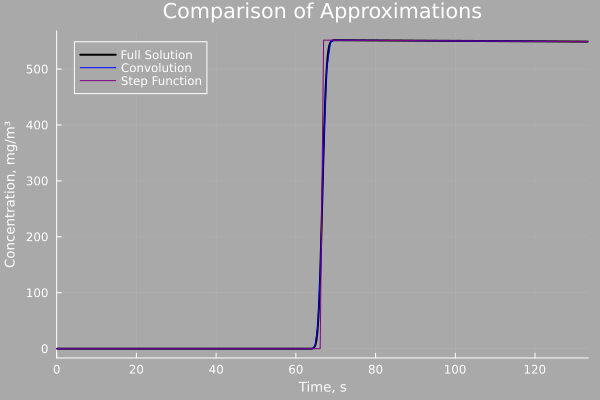

In [19]:
#| echo: false
#| label: fig-approx
#| fig-cap: "Approximations to the full integration of the linear ventillation model."
let
    function c_heaviside(t, μ=d/u, λ=λ₀, cmax=551.6845234598728)
        if t < μ
            return 0.0
        else
            return cmax*exp(-λ*(t-μ))
        end
    end
    approx1 = [ c(t′) for t′ in sln1.t ]
    approx2 = [ c_heaviside(t′) for t′ in sln1.t ]
    
    p1= plot(sln1, lab="Full Solution", color=:black, linewidth=2)
    plot!(p1, sln1.t, approx1, color=:blue, lab="Convolution")
    plot!(p1, sln1.t, approx2, color=:purple, lab="Step Function")
    plot!(p1, title="Comparison of Approximations",
          background_color=:darkgrey, foreground_color=:white,
          ylabel= "Concentration, mg/m³", 
          xlabel="Time, s",
          labelfontsize=9,
          legend=:topleft,
          legendtitlefontsize=8,
          size=(600,400))

end

### Atmospheric stability

The sensitivity to atmospheric stability, at the max windspeed given in the table of dispersion parameters above, is shown below. Clearly the indoor concentration depends strongly on the atmospheric stability, and that makes sense as more unstable conditions lead to far greater mixing and thus lower outdoor concentrations. This effect is far greater than any increase in ventilation rate due to the greater windspeeds.

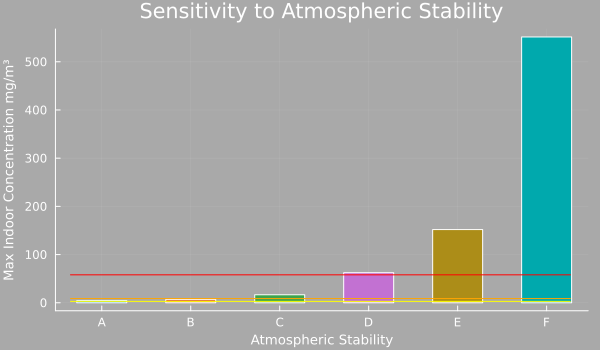

In [20]:
#| echo: false
#| label: fig-sens-stab
#| fig-cap: "Sensitivity of max indoor concentration to atmospheric stability"

struct Case
    name
    u
    σx::Function
    σy::Function
    σz::Function
end

function max_indoor(u′, sx, sy, sz)
    
    λ′ = λ(0.0, u′, Aₗ=Aₗ, V=V, Cs=14.5e-3, Cw=31.9e-3)
    
    #cₒ(t) = C(d, 0, h, t; m=m, u=u, h=h, σx=σx, σy=σy, σz=σz)*1e6
    #c0 = 0.0       # initial condition
    #sys = f(cₒ)

    #span = (0.0, 2*d/u)
    #prb = ODEProblem(sys, c0, span, λ₀)
    #sln = solve(prb, Tsit5(), dtmax=1)
    
    g(t) = cᵢ(d, 0, h, t, m=m, u=u′, h=h, λ=λ′, σx=sx, σy=sy, σz=sz)*1e6
    
    ∂g(t) = ForwardDiff.derivative(t -> g(t), float(t))
        
    tₘₐₓ = find_zero(∂g, d/u′)
    
    return g(tₘₐₓ)
    
end

function max_indoor(case::Case)
    return max_indoor(case.u, case.σx, case.σy, case.σz)
end

cases = [
    Case("A", 3.0,
          (x)-> 0.18*x^0.92,
          (x)-> 0.18*x^0.92,
          (x)-> 0.60*x^0.75),
    Case("B", 5.0,
          (x)-> 0.14*x^0.92,
          (x)-> 0.14*x^0.92,
          (x)-> 0.53*x^0.73),
    Case("C", 6.0,
          (x)-> 0.10*x^0.92,
          (x)-> 0.10*x^0.92,
          (x)-> 0.34*x^0.71),
    Case("D", 7.0,
          (x)-> 0.06*x^0.92,
          (x)-> 0.06*x^0.92,
          (x)-> 0.15*x^0.70),
    Case("E", 5.0,
          (x)-> 0.04*x^0.92,
          (x)-> 0.04*x^0.92,
          (x)-> 0.10*x^0.65),
    Case("F", 3.0,
          (x)-> 0.02*x^0.89,
          (x)-> 0.02*x^0.89,
          (x)-> 0.05*x^0.61)
]

bar([[case.name] for case in cases], [[max_indoor(case)] for case in cases],
    legend=false,
    title="Sensitivity to Atmospheric Stability",
    ylabel="Max Indoor Concentration mg/m³",
    xlabel="Atmospheric Stability",
    labelfontsize=9,
    background_color=:darkgrey, foreground_color=:white, size=(600,350))
plot!([0, 8], [erpg1, erpg1].*1e6,
     seriestype= :line,
     linewidth=1, color=:yellow)
plot!([0, 8], [erpg2, erpg2].*1e6,
     seriestype= :line,
     linewidth=1, color=:orange)
plot!([0, 8], [erpg3, erpg3].*1e6,
     seriestype= :line,
     linewidth=1, color=:red)

### Windspeed

Returning to the original scenario parameters we explore the impact of changing the windspeed, while assuming the atmospheric stability remains constant, in the figure below. In this case windspeed impacts both the parameters of the gaussian puff model and the natural ventilation rate in the single zone building infiltration model.

In [21]:
#| echo: false
#| label: fig-sens-windspeed
#| fig-cap: "Sensitivity of indoor concentration to outdoor windspeed."
λ(u) = λ(0.0, u, Aₗ=Aₗ, V=V, Cs=14.5e-3, Cw=31.9e-3)

let 
    us = collect(1:1:6)
    ts1 = collect(0:.2:150)
    ts2 = collect(0:1:2.5*(1/λ₀))
    labs = [ "$(round(j; digits=1)) m/s" for j in us ]

    ys1 = [ cᵢ(d, 0, h, t′, m=m, u=u′, h=h, λ=λ(u′), σx=σx, σy=σy, σz=σz)*1e6 for t′ in ts1, u′ in us ]
    ys2 = [ cᵢ(d, 0, h, t′, m=m, u=u′, h=h, λ=λ(u′), σx=σx, σy=σy, σz=σz)*1e6 for t′ in ts2, u′ in us ]
    
    p1 = plot(ts1, [ys1], lab=reshape(labs, (1, length(labs))),
         linewidth = 2,
         legendtitle="Windspeed", legend=:right,
         background_color=:darkgrey, foreground_color=:white,
         title="Sensitivity to Windspeed",
         labelfontsize=9,
         xlabel="Time, s",
         ylabel="Indoor Concentration, mg/m³")
    plot!(p1, [ts1[1], ts1[end]], [erpg1, erpg1].*1e6, color=:yellow, lab=false)
    plot!(p1, [ts1[1], ts1[end]], [erpg2, erpg2].*1e6, color=:orange, lab=false)
    plot!(p1, [ts1[1], ts1[end]], [erpg3, erpg3].*1e6, color=:red, lab=false)
    
    p2 = plot(ts2, [ys2], lab=reshape(us, (1, length(us))),
         linewidth = 2,
         legend=false,
         background_color=:darkgrey, foreground_color=:white,
         labelfontsize=9,
         xlabel="Time, s",
         ylabel="Indoor Concentration, mg/m³")
    plot!(p2, [ts2[1], ts2[end]], [erpg1, erpg1].*1e6, color=:yellow, lab=false)
    plot!(p2, [ts2[1], ts2[end]], [erpg2, erpg2].*1e6, color=:orange, lab=false)
    plot!(p2, [ts2[1], ts2[end]], [erpg3, erpg3].*1e6, color=:red, lab=false)
    
    l = @layout [a; b]
    plot(p1, p2, layout=l, size=(600,700))
end

This was, to me, a surprising result. I expected the max indoor concentration to depend strongly on the windspeed whereas it appears to have far more to do with how quickly the indoor build up of Chlorine dissipates. This is due to the difference in timescales between the puff passing over the building and the single zone building infiltration model.

The time-scale of interest for the puff model is the width of the gaussian $\sigma_t$, whereas the time-scale of interest for the building infiltration model is the time constant of the exponential decay $\tau = \frac{1}{\lambda}$, for this situation with a class F atmospheric stability they are

In [22]:
σₜ = σx(d)/u

0.8034127814324771

In [23]:
τ = 1/λ₀

13794.453168477568

In [24]:
σₜ/τ

5.82417274262381e-5

The time it takes the cloud to pass is simply orders of magnitude faster than the response of the infiltration model. So, in effect, the puff is acting like a impulse -- causing a step change -- and changing the windspeed merely moves the time at which that step change takes place. The faster the windspeed the better the approximation $ \mathrm{erfc}(-x) \approx 2 H(x) $ gets and if we take another look at the approximation for max concentration, we see it is independent of windspeed.

Note that for the simplified ASHRAE model with $\Delta T = 0$ the natural ventilation rate is directly proportional to windspeed, i.e. $ \lambda = k u $ where *k* is all the vaious constants of that model collected for convenience, plugging this into the approximation we find the windspeed cancels out entirely.

$$ { \lambda C_1 \over u } \exp \left( { \left( \lambda \sigma_t \right)^2 \over 2 } \right) $$

$$ = { { k u C_1 } \over u } \exp \left( { \left( k u \frac{\sigma_x}{u} \right)^2 \over 2 } \right) $$

$$ = k C_1 \exp \left( { \left( k \sigma_x \right)^2 \over 2 } \right) $$

Which is independent of windspeed.

We can perhaps see how small the effect is more clearly by directly varying the ratio ${ \sigma_t \over \tau}$ while keeping $\mu$ constant and looking at the response. The maximum indoor concentration does change, but only slightly.

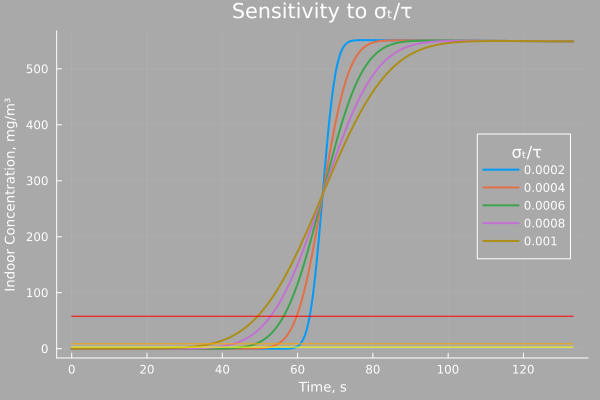

In [25]:
#| echo: false
#| label: fig-sens-sigma-tau
#| fig-cap: "Sensitivity of the indoor concentration to the ratio &sigma;<sub>t</sub>/&tau;"
let 

    u′ = 1.5 #m/s
    λ′ = λ(u′)
    d′ = 100
      

    ts1 = collect(0:.2:2*(d′/u′))
    sxs = [ (x)-> k for k in collect(2:2:10).*(u′/λ′).*0.0001 ]
    labs = [ "$(round(j; digits=4))" for j in collect(2:2:10).*0.0001 ]

    ys1 = [ cᵢ(d′, 0, h, t′, m=m, u=u′, h=h, λ=λ′, σx=sx, σy=σy, σz=σz)*1e6 for t′ in ts1, sx in sxs ]
    
    p1 = plot(ts1, [ys1], lab=reshape(labs, (1, length(labs))),
         linewidth = 2,
         legendtitle="σₜ/τ", legend=:right,
         background_color=:darkgrey, foreground_color=:white,
         title="Sensitivity to σₜ/τ",
         labelfontsize=9,
         xlabel="Time, s",
         ylabel="Indoor Concentration, mg/m³")
    plot!(p1, [ts1[1], ts1[end]], [erpg1, erpg1].*1e6, color=:yellow, lab=false)
    plot!(p1, [ts1[1], ts1[end]], [erpg2, erpg2].*1e6, color=:orange, lab=false)
    plot!(p1, [ts1[1], ts1[end]], [erpg3, erpg3].*1e6, color=:red, lab=false)
    
    plot(p1)
        
end

Which is not to say the model is insensitive to the natural ventilation rate, merely that for a given building the impact of changing windspeed on the ventilation rate is canceled out by the change in the outdoor concentration profile.

### Equivalent Leak Area

Below the equivalent leak area $A_L$ is varied while keeping all other parameters constant. Unsurprisingly building tightness matters, and the impact is approximately linear. This is intuitive, of course, because the outside concentration does not depend in any way on the leakage area and so there is no canceling of effects like was seen with windspeed, and of course having more leaks leads to more of the outside air getting inside.

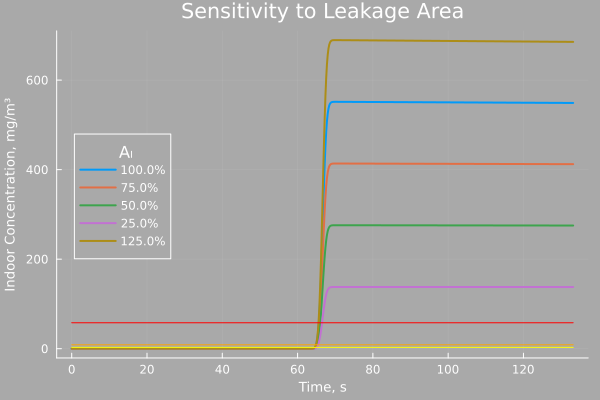

In [26]:
#| echo: false
#| label: fig-sens-leak-area
#| fig-cap: "Sensitivity of indoor concentration to the leakage area."
let 

    u′ = 1.5 #m/s
    d′ = 100
    
    rs = [1, 0.75, 0.5, 0.25, 1.25]
    ts1 = collect(0:.2:2*(d′/u′))
    λs = [ λ(0.0, u′, Aₗ=A, V=V, Cs=14.5e-3, Cw=31.9e-3) for A in rs.*Aₗ ]
    labs = [ "$(round(j*100; digits=1))%" for j in rs ]

    ys1 = [ cᵢ(d′, 0, h, t′, m=m, u=u′, h=h, λ=λ′, σx=σx, σy=σy, σz=σz)*1e6 for t′ in ts1, λ′ in λs ]
    
    p1 = plot(ts1, [ys1], lab=reshape(labs, (1, length(labs))),
         linewidth = 2,
         legendtitle="Aₗ", legend=:left,
         background_color=:darkgrey, foreground_color=:white,
         title="Sensitivity to Leakage Area",
         labelfontsize=9,
         xlabel="Time, s",
         ylabel="Indoor Concentration, mg/m³")
    plot!(p1, [ts1[1], ts1[end]], [erpg1, erpg1].*1e6, color=:yellow, lab=false)
    plot!(p1, [ts1[1], ts1[end]], [erpg2, erpg2].*1e6, color=:orange, lab=false)
    plot!(p1, [ts1[1], ts1[end]], [erpg3, erpg3].*1e6, color=:red, lab=false)
    
    plot(p1)
        
end

### Temperature

A similar effect as was seen with equivalent leak area is present with changes in the temperature difference between indoors and outdoors. Though in this case the change goes with the square-root of the temperature difference.

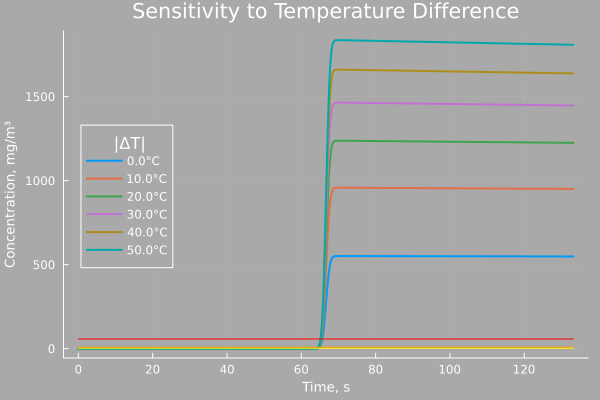

In [27]:
#| echo: false
#| label: fig-sens-temperature
#| fig-cap: "Sensitivity of indoor concentration to the indoor-outdoor temperature difference"
let 

    u′ = 1.5 #m/s
    d′ = 100
    
    ts1 = collect(0:.2:2*(d′/u′))
    Ts = [ 0, 10, 20, 30, 40, 50 ]
    λs = [ λ(T, u′, Aₗ=Aₗ, V=V, Cs=14.5e-3, Cw=31.9e-3) for T in Ts ]
    labs = [ "$(round(j; digits=1))°C" for j in Ts ]

    ys1 = [ cᵢ(d′, 0, h, t′, m=m, u=u′, h=h, λ=λ′, σx=σx, σy=σy, σz=σz)*1e6 for t′ in ts1, λ′ in λs ]
    
    p1 = plot(ts1, [ys1], lab=reshape(labs, (1, length(labs))),
         linewidth = 2,
         legendtitle="|ΔT|", legend=:left,
         background_color=:darkgrey, foreground_color=:white,
         title="Sensitivity to Temperature Difference",
         labelfontsize=9,
         xlabel="Time, s",
         ylabel="Concentration, mg/m³")
    plot!(p1, [ts1[1], ts1[end]], [erpg1, erpg1].*1e6, color=:yellow, lab=false)
    plot!(p1, [ts1[1], ts1[end]], [erpg2, erpg2].*1e6, color=:orange, lab=false)
    plot!(p1, [ts1[1], ts1[end]], [erpg3, erpg3].*1e6, color=:red, lab=false)
    
    plot(p1)
        
end

On a summer day like today large temperature differences like this might seem extreme, but in the depths of winter when days around here routinely get to -30°C a standard heated building with a normal indoor temperature around 20°C would have a 50°C temperature difference with the outdoors.

### Distance

The most obvious case of interest, however, is how far downwind would the *building* have to be such that it did not exceed the ERPG limits. With all other parameters equal to the scenario, the max indoor concentration as a function of building distance is shown in the figure below.

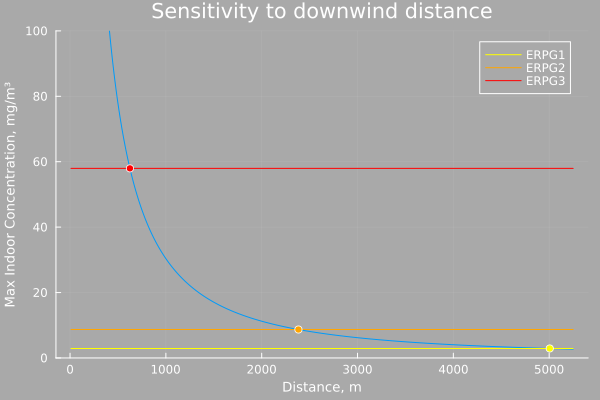

Downwind distance to ERPG-3 (indoors) 625.0m
Downwind distance to ERPG-2 (indoors) 2383.0m
Downwind distance to ERPG-1 (indoors) 5006.0m


In [28]:
#| echo: false
#| label: fig-sens-dist
#| fig-cap: Max indoor concentration as a function of downwind distance to the receptor.

function max_indoor_distance(x)
    
    t′ = x/u
    
    g(t) = cᵢ(x, 0, h, t, m=m, u=u, h=h, λ=λ₀, σx=σx, σy=σy, σz=σz)*1e6
    
    ∂g(t) = ForwardDiff.derivative(t -> g(t), float(t))
        
    tₘₐₓ = find_zero(∂g, t′)
    
    return g(tₘₐₓ)

end

let
    ds = collect( 10:10:5250 )
    
    ys = max_indoor_distance.(ds)
    
    dist_erpg1 = find_zero((x) -> max_indoor_distance(x) - erpg1*1e6, 2500)
    dist_erpg2 = find_zero((x) -> max_indoor_distance(x) - erpg2*1e6, 2500)
    dist_erpg3 = find_zero((x) -> max_indoor_distance(x) - erpg3*1e6, 600)
    
    p1 = plot(ds, ys, lab=false,
         background_color=:darkgrey, foreground_color=:white,
         title="Sensitivity to downwind distance",
         labelfontsize=9,
         xlabel="Distance, m",
         ylabel="Max Indoor Concentration, mg/m³",
         ylim=(0, 100.0))
    plot!(p1, [ds[1], ds[end]], [erpg1, erpg1].*1e6, color=:yellow, lab="ERPG1")
    plot!(p1, [ds[1], ds[end]], [erpg2, erpg2].*1e6, color=:orange, lab="ERPG2")
    plot!(p1, [ds[1], ds[end]], [erpg3, erpg3].*1e6, color=:red, lab="ERPG3")
    plot!(p1, [dist_erpg3], [erpg3*1e6], lab=false, seriestype=:scatter, color=:red)
    plot!(p1, [dist_erpg2], [erpg2*1e6], lab=false, seriestype=:scatter, color=:orange)
    plot!(p1, [dist_erpg1], [erpg1*1e6], lab=false, seriestype=:scatter, color=:yellow)
    
    display(p1)
    println("Downwind distance to ERPG-3 (indoors) $(round(dist_erpg3; digits=0))m")
    println("Downwind distance to ERPG-2 (indoors) $(round(dist_erpg2; digits=0))m")
    println("Downwind distance to ERPG-1 (indoors) $(round(dist_erpg1; digits=0))m")
    
end

As was seen above when examining the outdoor concentrations, this is a significant release and the downwind distance is large. This also shows the value of sheltering in place as an unprotected individual would have to travel downwind for many tens of kilometers to reach a safe distance, whereas indoors that is greatly reduced.

Again, this is all considering the instantaneous concentration and not considering dose.

## Final Remarks

The results of the scenario speak to something the previous discussion noted, namely that after the cloud has passed the indoor concentration exceeds the outdoor concentration and so an important response, post release, is not just when to shelter in place but when to stop.

The worst case indoor concentration far exceeded the ERPG-3 limit, however it was still significantly lower exposure than had one been standing outside. But once the chlorine had leaked into the building it would take hours to fully clear purely by natural ventilation. At that point it would be far more prudent to leave the building and to turn the ventilation system back on. Identifying when this is the case is an interesting problem, because there are no guarantees that the emergency outside the building is fully resolved merely because the toxic release has passed. So one must balance the risks of sheltering in a place that is no longer safe versus evacuating into a potentially dangerous environment. In such a scenario it may be prudent to have indoor and outdoor air monitoring in the shelter in place location and a store of emergency escape respirators, though a better solution would be to move the shelter in place to a safer location.

These two examples cover two extremes of building infiltration, the forest fire smoke looked at enormous clouds that take hours to pass and this chlorine example covers very concentrated clouds which pass in under a minute. Most real scenarios at a chemical plant or other facility are likely to be between these extremes, but the same tools would apply.

## References
::: {#refs}
:::